In [109]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import collections
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import random
import os
import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = torch.device('cuda')

In [278]:
CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))


class GPCurvesReader(object):
  """Generates curves using a Gaussian Process (GP).

  Supports vector inputs (x) and vector outputs (y). Kernel is
  mean-squared exponential, using the x-value l2 coordinate distance scaled by
  some factor chosen randomly in a range. Outputs are independent gaussian
  processes.
  """

  def __init__(self,
               batch_size,
               max_num_context,
               x_size=1,
               y_size=1,
               l1_scale=0.4,
               sigma_scale=1.0,
               testing=False):
    """Creates a regression dataset of functions sampled from a GP.

    Args:
      batch_size: An integer.
      max_num_context: The max number of observations in the context.
      x_size: Integer >= 1 for length of "x values" vector.
      y_size: Integer >= 1 for length of "y values" vector.
      l1_scale: Float; typical scale for kernel distance function.
      sigma_scale: Float; typical scale for variance.
      testing: Boolean that indicates whether we are testing. If so there are
          more targets for visualization.
    """
    self._batch_size = batch_size
    self._max_num_context = max_num_context
    self._x_size = x_size
    self._y_size = y_size
    self._l1_scale = l1_scale
    self._sigma_scale = sigma_scale
    self._testing = testing

  def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
    """Applies the Gaussian kernel to generate curve data.

    Args:
      xdata: Tensor with shape `[batch_size, num_total_points, x_size]` with
          the values of the x-axis data.
      l1: Tensor with shape `[batch_size, y_size, x_size]`, the scale
          parameter of the Gaussian kernel.
      sigma_f: Float tensor with shape `[batch_size, y_size]`; the magnitude
          of the std.
      sigma_noise: Float, std of the noise that we add for stability.

    Returns:
      The kernel, a float tensor with shape
      `[batch_size, y_size, num_total_points, num_total_points]`.
    """
    num_total_points = xdata.size(1)

    # Expand and take the difference
#     xdata1 = tf.expand_dims(xdata, axis=1)  # [B, 1, num_total_points, x_size]
    xdata1 = xdata.unsqueeze(1)
    xdata2 = xdata.unsqueeze(2)
#     xdata2 = tf.expand_dims(xdata, axis=2)  # [B, num_total_points, 1, x_size]
    diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]
    diff = diff.type(torch.DoubleTensor)
    l1 = l1.type(torch.DoubleTensor)
    # [B, y_size, num_total_points, num_total_points, x_size]
    norm = (diff[:, None, :, :, :] / l1[:, :, None, None, :])**2
    norm = torch.sum(norm, dim=-1).type(torch.DoubleTensor)
    
#     norm = tf.reduce_sum(
#         norm, -1)  # [B, data_size, num_total_points, num_total_points]

    # [B, y_size, num_total_points, num_total_points]
#     kernel = tf.square(sigma_f)[:, :, None, None] * tf.exp(-0.5 * norm)
    sigma_f = sigma_f.type(torch.DoubleTensor)
    kernel = (sigma_f**2)[:, :, None, None] * torch.exp(-0.5 * norm)

    # Add some noise to the diagonal to make the cholesky work.
    kernel += (sigma_noise**2) * torch.eye(num_total_points).type(torch.DoubleTensor)

    return kernel

  def generate_curves(self):
    """Builds the op delivering the data.

    Generated functions are `float32` with x values between -2 and 2.
    
    Returns:
      A `CNPRegressionDescription` namedtuple.
    """
    num_context = 5

    # If we are testing we want to have more targets and have them evenly
    # distributed in order to plot the function.
    if self._testing:
        num_target = 400
        num_total_points = num_target
        x_values = torch.from_numpy(np.arange(-2., 2., 1./100)).to(device)

        x_values = x_values.unsqueeze(0)
        x_values = x_values.repeat(self._batch_size, 1)
        x_values = x_values.unsqueeze(-1)
    # During training the number of target points and their x-positions are
    # selected at random
    else:
        num_target = random.randrange(2, self._max_num_context)
        num_total_points = num_context + num_target
        x_values = torch.from_numpy(np.random.uniform(-2, 2,
          (self._batch_size, num_total_points, self._x_size))).to(device)

    # Set kernel parameters
    l1 = (
        torch.ones((self._batch_size, self._y_size, self._x_size), device=device) *
        self._l1_scale)
    sigma_f = torch.ones(
        (self._batch_size, self._y_size), device=device) * self._sigma_scale

    # Pass the x_values through the Gaussian kernel
    # [batch_size, y_size, num_total_points, num_total_points]
    kernel = self._gaussian_kernel(x_values, l1, sigma_f).type(torch.DoubleTensor)

    # Calculate Cholesky, using double precision for better stability:
    cholesky = torch.cholesky(kernel.float()).float()

    # Sample a curve
    # [batch_size, y_size, num_total_points, 1]
    y_values = torch.matmul(cholesky, torch.nn.init.normal_(torch.rand(self._batch_size, self._y_size, num_total_points, 1)))

    # [batch_size, num_total_points, y_size]
    y_values = y_values.squeeze(3).permute(0, 2, 1)
    x_values = x_values.to(device)
    y_values = y_values.to(device)

    if self._testing:
        target_x = x_values
        target_y = y_values

        idx = np.arange(num_target)
        random.shuffle(idx)
        idx = torch.from_numpy(idx).to(device)
        context_x = torch.index_select(x_values, 1, idx[:num_context])
        context_y = torch.index_select(y_values, 1, idx[:num_context])
        


    else:
      # Select the targets which will consist of the context points as well as
      # some new target points
        target_x = x_values[:, :num_target + num_context, :]
        target_y = y_values[:, :num_target + num_context, :]
        context_x = x_values[:, :num_context, :]
        context_y = y_values[:, :num_context, :]

    query = ((context_x, context_y), target_x)

    return CNPRegressionDescription(
        query=query,
        target_y=target_y,
        num_total_points=target_x.size(1),
        num_context_points=num_context)


In [286]:
class DeterministicEncoder(nn.Module):
    def __init__(self, out_dim):
        super(DeterministicEncoder, self).__init__()
        self.h1 = nn.Linear(2, out_dim)
        self.h2 = nn.Linear(out_dim, out_dim)
        self.h3 = nn.Linear(out_dim, out_dim)
        self.h4 = nn.Linear(out_dim, out_dim)
        self.a = nn.ReLU()
    
    def forward(self, context_x, context_y, num_context_points):
        context_x = context_x.type(torch.DoubleTensor)
        context_y = context_y.type(torch.DoubleTensor)
        encoder_input = torch.cat([context_x, context_y], dim=-1).cuda()
        
        batch_size, _, filter_size = encoder_input.size()
        hidden = encoder_input.view(batch_size * num_context_points, -1)
        hidden = hidden.type(torch.FloatTensor).cuda()
        hidden = self.a(self.h1(hidden))
        hidden = self.a(self.h2(hidden))
        hidden = self.a(self.h3(hidden))
        hidden = self.h4(hidden)
        hidden = hidden.view(batch_size, num_context_points, out_dim)
        representation = torch.mean(hidden, dim=1)
        return representation

In [287]:
class DeterministicDecoder(nn.Module):
    def __init__(self, out_dim):
        super(DeterministicDecoder, self).__init__()
        self.h1 = nn.Linear(out_dim + 1, out_dim)
        self.h2 = nn.Linear(out_dim, out_dim)
        self.h3 = nn.Linear(out_dim, out_dim)
        self.h4 = nn.Linear(out_dim, 2)
        self.a = nn.ReLU()
        self.softplus = nn.Softplus()
        
    def forward(self, representation, target_x, num_total_points):
        representation = representation.unsqueeze(1)
        representation = representation.repeat((1, num_total_points, 1))
        representation = representation.type(torch.FloatTensor)
        target_x = target_x.type(torch.FloatTensor)
        input_ = torch.cat((representation, target_x), dim=-1)
        batch_size, _, filter_size = input_.size()
        hidden = input_.view(batch_size * num_total_points, -1)
        hidden = hidden.to(device)
        hidden = self.a(self.h1(hidden))
        hidden = self.a(self.h2(hidden))
        hidden = self.a(self.h3(hidden))
        hidden = self.h4(hidden)
        
        hidden = hidden.view(batch_size, num_total_points, -1)
        mu, log_sigma = torch.split(hidden, 1, dim=-1)
        sigma = 0.1 + 0.9 * self.softplus(log_sigma)

        dist = torch.distributions.MultivariateNormal(loc=mu, scale_tril=sigma.transpose(0, 1))
        return dist, mu, sigma

In [288]:
nn.Softplus(2.3)

Softplus(beta=2.3, threshold=20)

In [289]:
class DeterministicModel(nn.Module):
    def __init__(self, encoder_output_size, decoder_output_size):
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_output_size)
        self._decoder = DeterministicDecoder(decoder_output_size)
    
    def forward(self, query, num_total_points, num_contexts, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y, num_contexts)
        dist, mu, sigma = self._decoder(representation, target_x, num_total_points)
        
        if target_y is not None:
            log_p = dist.log_prob(target_y)
        else:
            log_p = None
        return log_p, mu, sigma

In [290]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
  """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape batchsize x number_targets x 1 that contains the
        x values of the target points.
    target_y: An array of shape batchsize x number_targets x 1 that contains the
        y values of the target points.
    context_x: An array of shape batchsize x number_context x 1 that contains 
        the x values of the context points.
    context_y: An array of shape batchsize x number_context x 1 that contains 
        the y values of the context points.
    pred_y: An array of shape batchsize x number_targets x 1  that contains the
        predicted means of the y values at the target points in target_x.
    pred_y: An array of shape batchsize x number_targets x 1  that contains the
        predicted variance of the y values at the target points in target_x.
  """
  # Plot everything
  plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
  plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
  plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
  plt.fill_between(
      target_x[0, :, 0],
      pred_y[0, :, 0] - var[0, :, 0],
      pred_y[0, :, 0] + var[0, :, 0],
      alpha=0.2,
      facecolor='#65c9f7',
      interpolate=True)

  # Make the plot pretty
  plt.yticks([-2, 0, 2], fontsize=16)
  plt.xticks([-2, 0, 2], fontsize=16)
  plt.ylim([-2, 2])
  plt.grid('off')
  ax = plt.gca()

  plt.show()

In [291]:

TRAINING_ITERATIONS = int(2e5)
MAX_CONTEXT_POINTS = 10
PLOT_AFTER = int(2e4)

# Train dataset
dataset_train = GPCurvesReader(
    batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
data_train = dataset_train.generate_curves()

# Test dataset
dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True)
data_test = dataset_test.generate_curves()

59.32521438598633


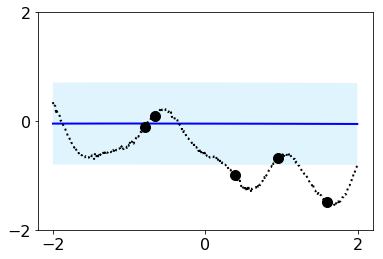

56.638458251953125


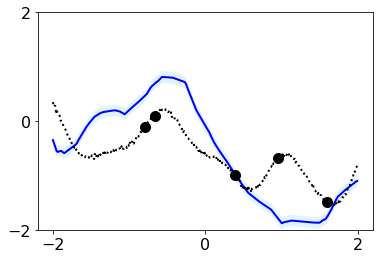

59.049556732177734


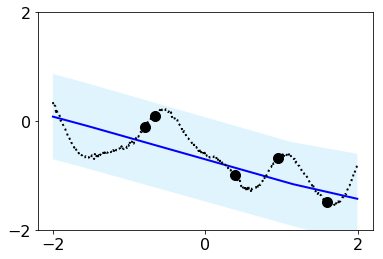

58.7332649230957


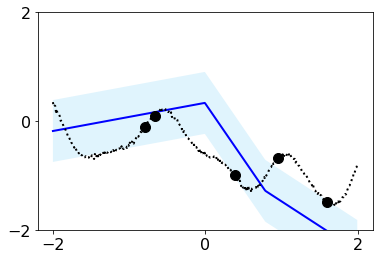

58.52610397338867


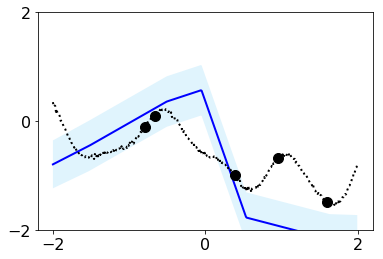

58.16119384765625


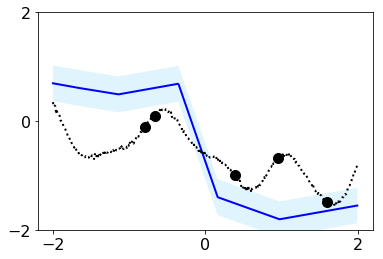

58.00391387939453


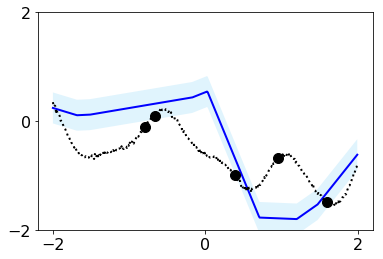

57.923683166503906


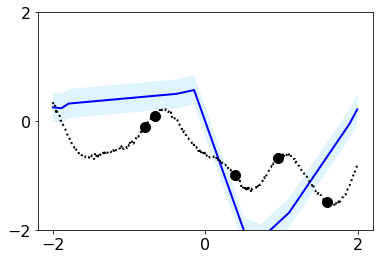

57.967750549316406


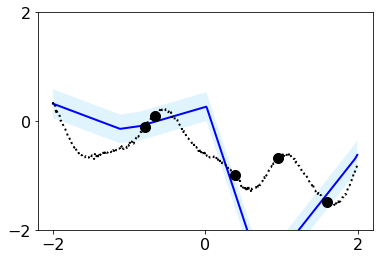

57.71748733520508


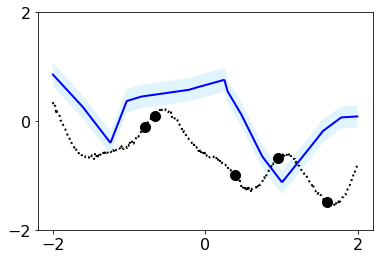

57.744300842285156


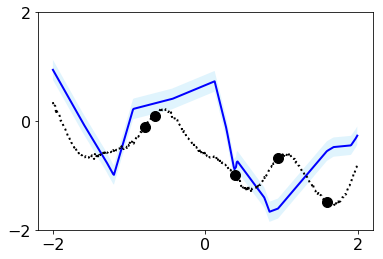

57.4541130065918


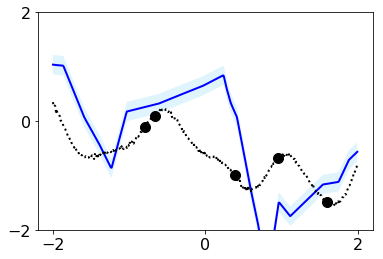

57.36356735229492


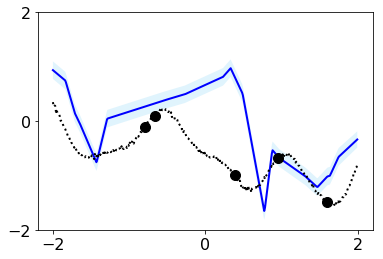

57.3499755859375


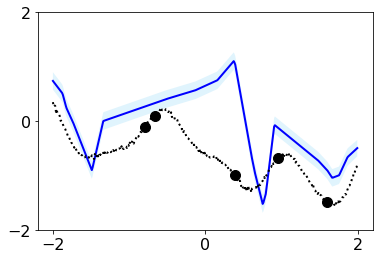

57.29893112182617


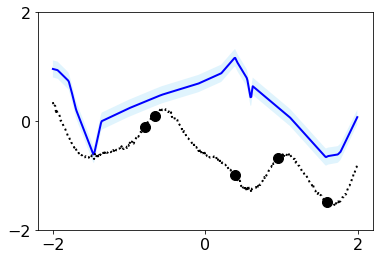

57.690120697021484


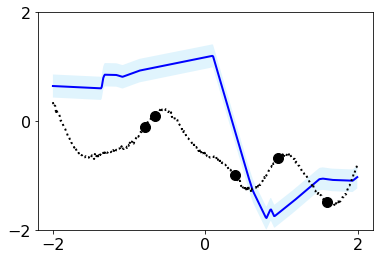

57.36161422729492


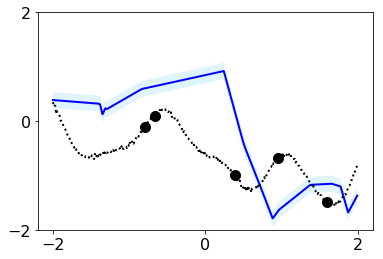

57.26165771484375


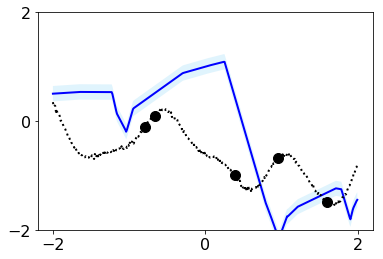

57.27485275268555


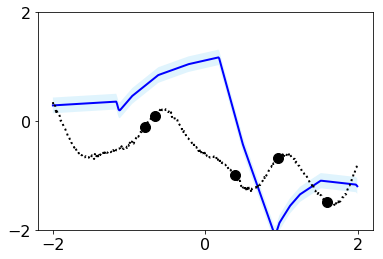

57.2529296875


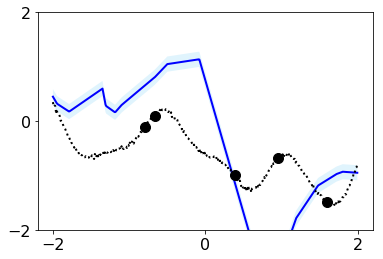

57.164649963378906


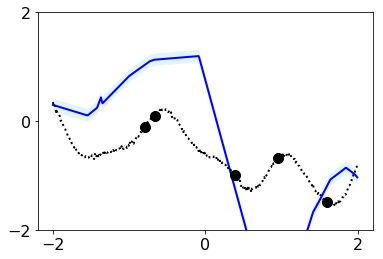

56.801918029785156


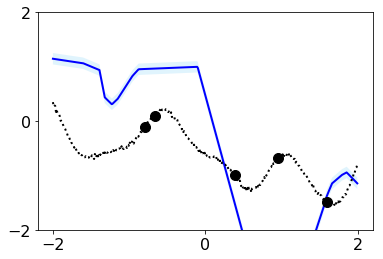

57.193824768066406


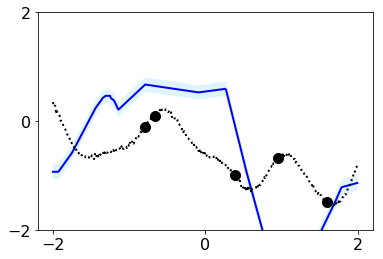

57.009681701660156


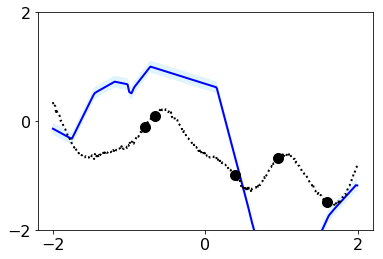

56.83237838745117


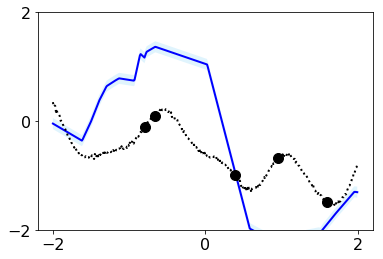

58.23455810546875


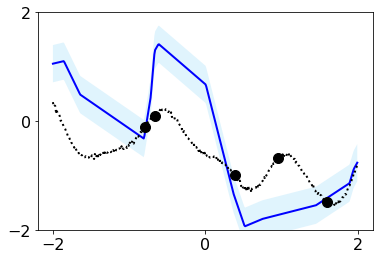

57.94780349731445


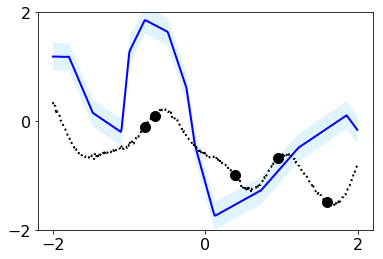

57.49524688720703


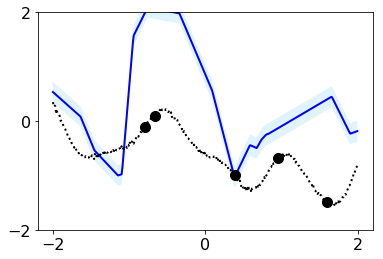

57.40357208251953


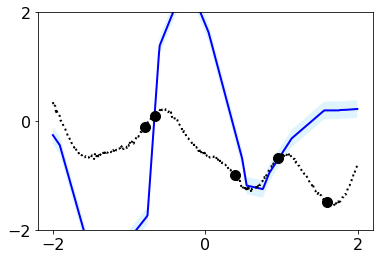

57.197914123535156


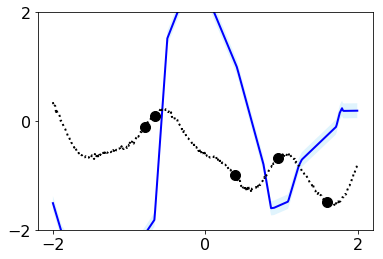

57.275611877441406


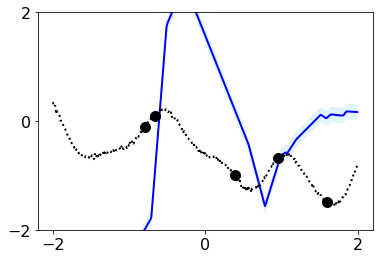

57.0615348815918


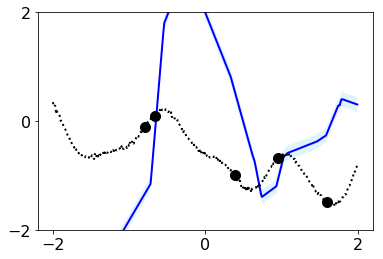

58.924407958984375


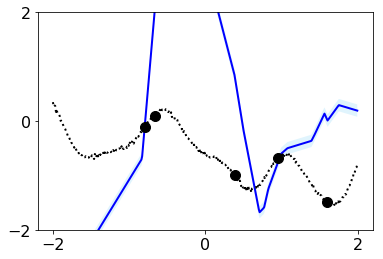

57.16433334350586


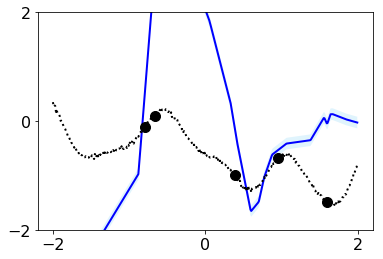

57.2945442199707


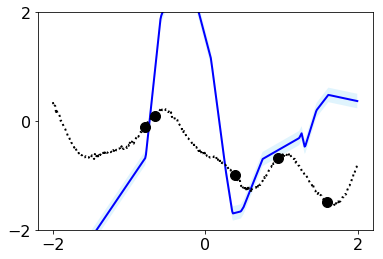

57.11489486694336


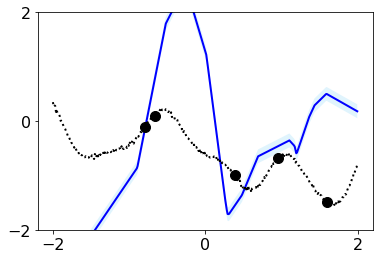

57.268768310546875


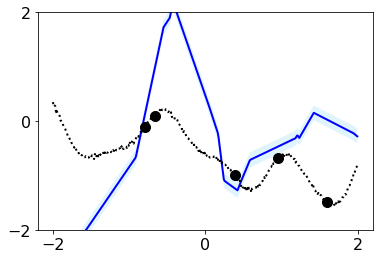

57.430416107177734


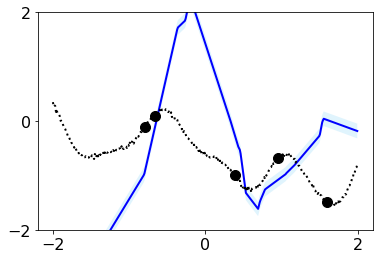

57.10352325439453


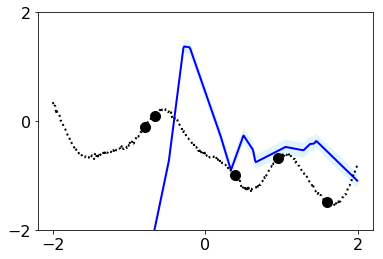

57.3536262512207


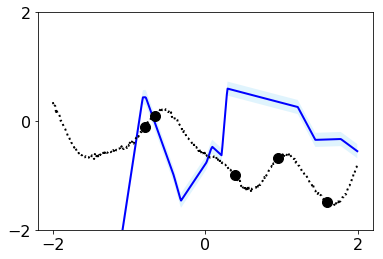

57.02724075317383


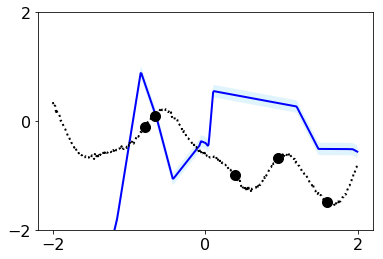

57.250343322753906


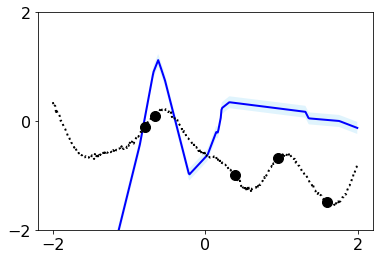

56.86497116088867


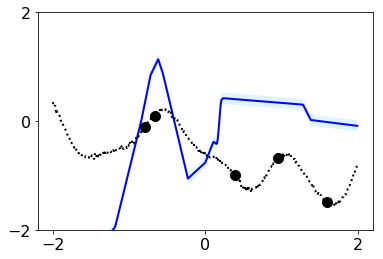

56.97870635986328


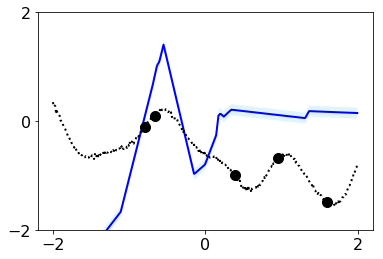

56.910682678222656


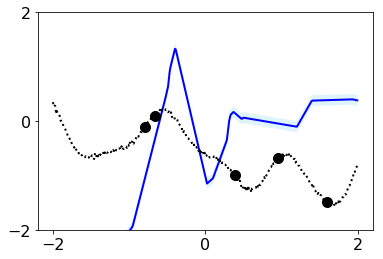

56.97703170776367


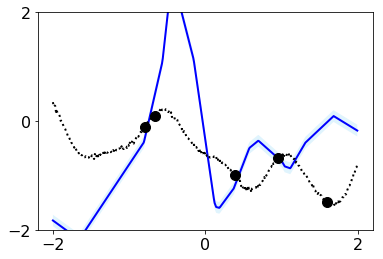

61.837398529052734


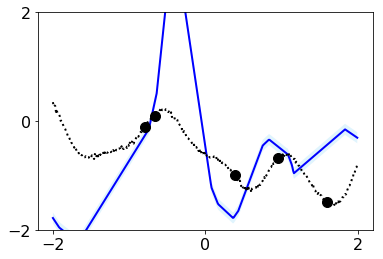

56.75381088256836


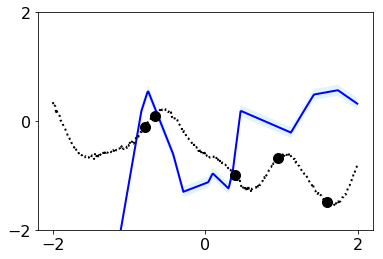

58.08163070678711


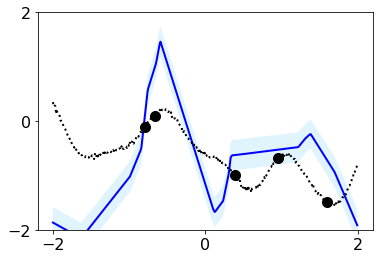

57.64263916015625


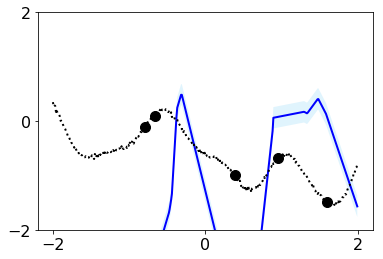

57.400146484375


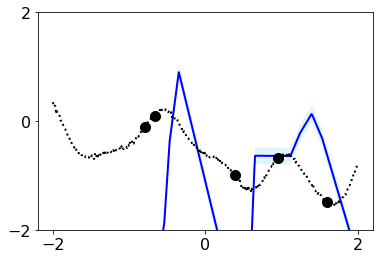

57.51263427734375


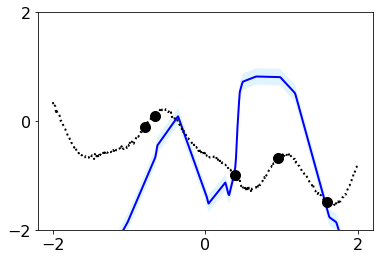

57.17378616333008


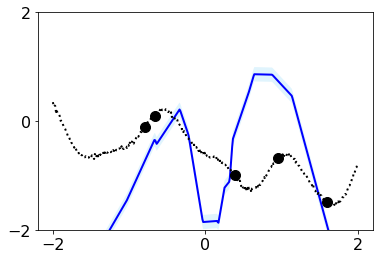

58.01627731323242


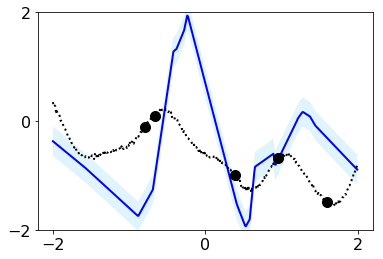

57.849090576171875


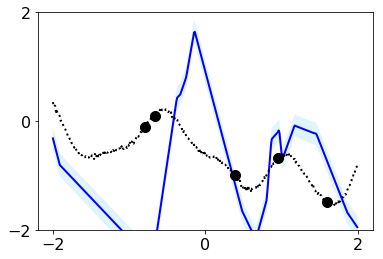

57.4224967956543


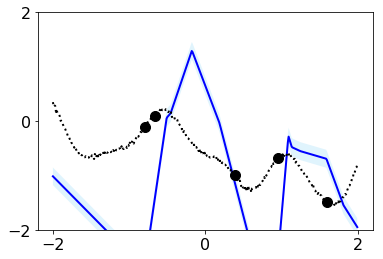

57.48604965209961


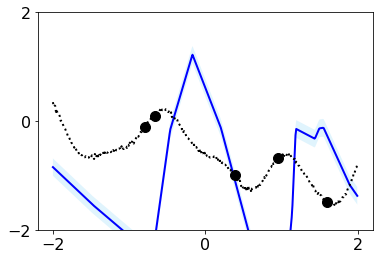

57.34103012084961


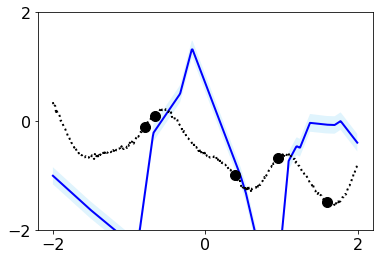

57.481109619140625


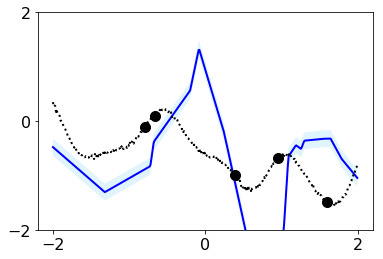

57.7515983581543


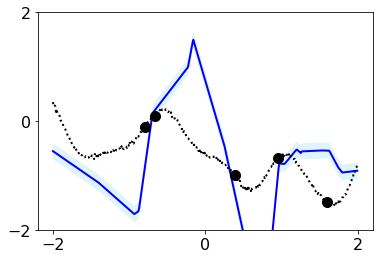

58.17973709106445


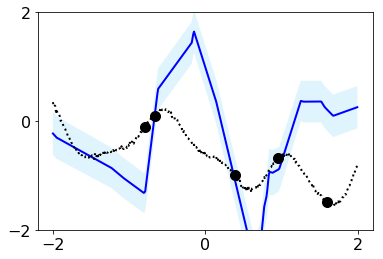

59.19009017944336


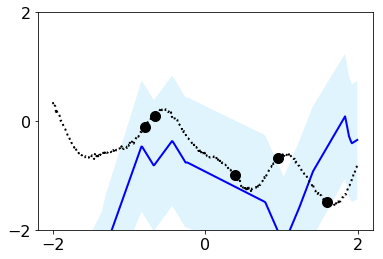

58.224239349365234


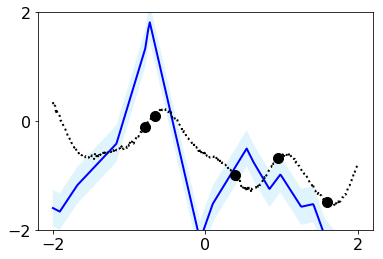

58.13153076171875


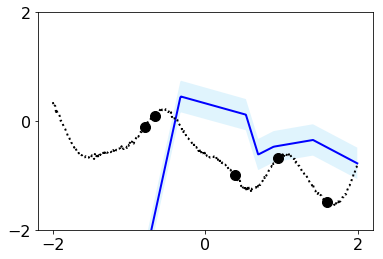

58.6943473815918


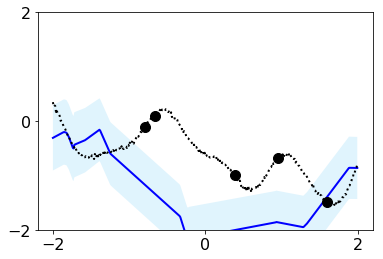

58.355224609375


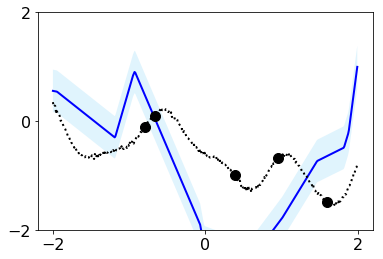

58.518829345703125


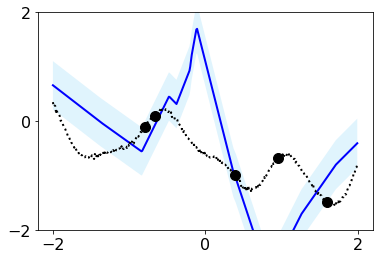

58.373016357421875


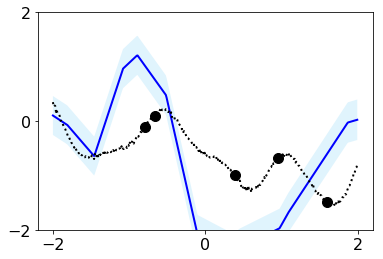

In [307]:
encod_dim = 128
out_dim = 128

model = DeterministicModel(encod_dim, out_dim)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for i in range(68000):
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.num_total_points, data_train.num_context_points, data_train.target_y)
    _, mu, sigma = model(data_test.query, data_test.num_total_points, data_test.num_context_points)
    loss = -torch.mean(log_prob)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(loss.item())
        (context_x, context_y), target_x = data_test.query
        plot_functions(target_x.detach().cpu().numpy(), data_test.target_y.cpu().detach().cpu().numpy(),
               context_x.detach().cpu().numpy(),
                       context_y.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy())